In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib的一些设置
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams['font.size'] = 18
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# numpy的设置
np.set_printoptions(suppress=True)


### 数据来自2017年摩洛哥Tétouan城市的用电量统计

In [23]:
df = pd.read_csv('Tetuan City power consumption.csv')
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,70425.53544
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,69320.84387
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,67803.22193
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,65489.23209
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,63650.44627


### 数据处理以及时间序列特征提取

In [24]:
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [25]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)
df.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Power Consumption,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,70425.53544,0,6,1,1,1,1,52
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,69320.84387,0,6,1,1,1,1,52
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,67803.22193,0,6,1,1,1,1,52
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,65489.23209,0,6,1,1,1,1,52
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,63650.44627,0,6,1,1,1,1,52


# 绘制箱线图

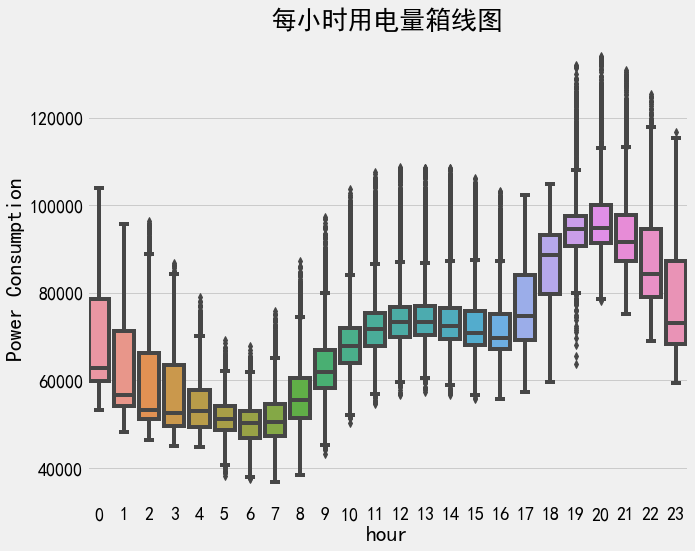

In [26]:
# 按小时
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Power Consumption')
ax.set_title('每小时用电量箱线图')
plt.tight_layout()
plt.savefig('hour.svg')
plt.show()

### 中午和晚上是用电量的高峰

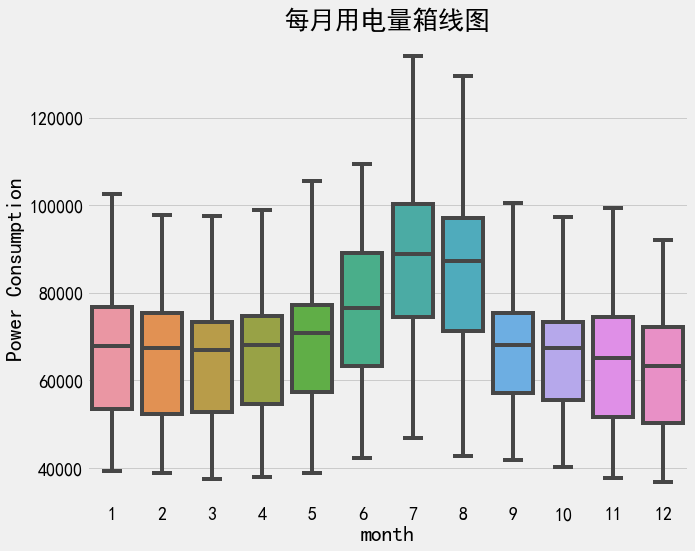

In [27]:
# 按月份
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Power Consumption')
ax.set_title('每月用电量箱线图')
plt.tight_layout()
plt.savefig('month.svg')
plt.show()

### 夏季是用电量高峰

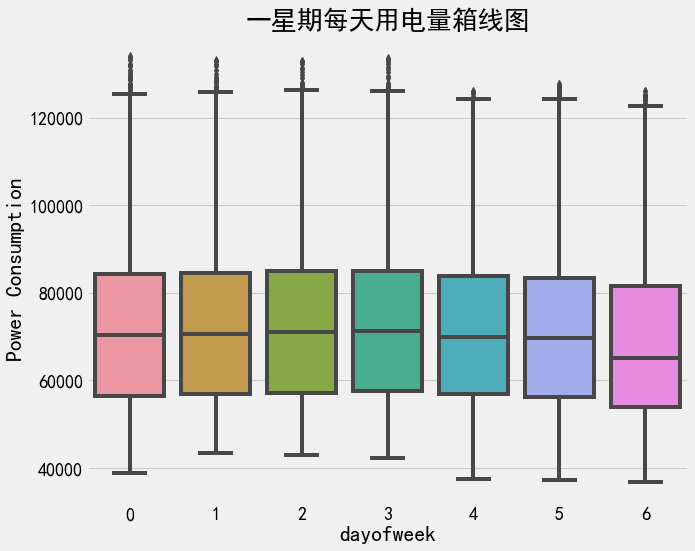

In [28]:
# 按小时
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Power Consumption')
ax.set_title('一星期每天用电量箱线图')
plt.tight_layout()
plt.savefig('dayofweek.svg')
plt.show()

### 星期天用电量最少

# 建模

In [29]:
X = df.loc[:,['Temperature', 'Wind Speed', 'hour', 'dayofweek', 'quarter', 'month']]
y = df.loc[:, ['Power Consumption']]

In [30]:
X = np.mat(X)
y = np.mat(y).reshape(-1,1)

In [31]:
def multivariate_linear_regression(X, y):
    # 添加截距列
    ones = np.ones((X.shape[0], 1))
    X = np.hstack((ones, X))
    
    # 求解正规方程组
    XT_X_inv = np.linalg.inv(X.T @ X)
    XT_y = X.T @ y
    beta = XT_X_inv @ XT_y
    
    return beta

# 计算最小二乘估计
beta = multivariate_linear_regression(X, y)

print("回归系数:")
print(beta)

回归系数:
[[36723.81338954]
 [ 1073.50585582]
 [  430.66425674]
 [ 1504.48723681]
 [ -515.64020648]
 [ 2698.53217691]
 [-1390.46776765]]


# 实验结果

### 通过模型预测用电数据

In [32]:
def batch_predict(X_new, beta):
    # 添加截距列
    ones = np.ones((X_new.shape[0], 1))
    X_new_with_intercept = np.hstack((ones, X_new))
    
    # 预测值
    Y_pred = X_new_with_intercept @ beta
    
    return Y_pred

Y_pred = batch_predict(X, beta)


print("预测用电量:")
print(Y_pred)
print("真实用电量:")
print(y)

预测用电量:
[[42014.9066016 ]
 [41859.2482525 ]
 [41749.53216829]
 ...
 [70301.56183084]
 [70146.54001377]
 [69955.88663569]]
真实用电量:
[[70425.53544]
 [69320.84387]
 [67803.22193]
 ...
 [68675.04965]
 [67163.01682]
 [65750.53976]]


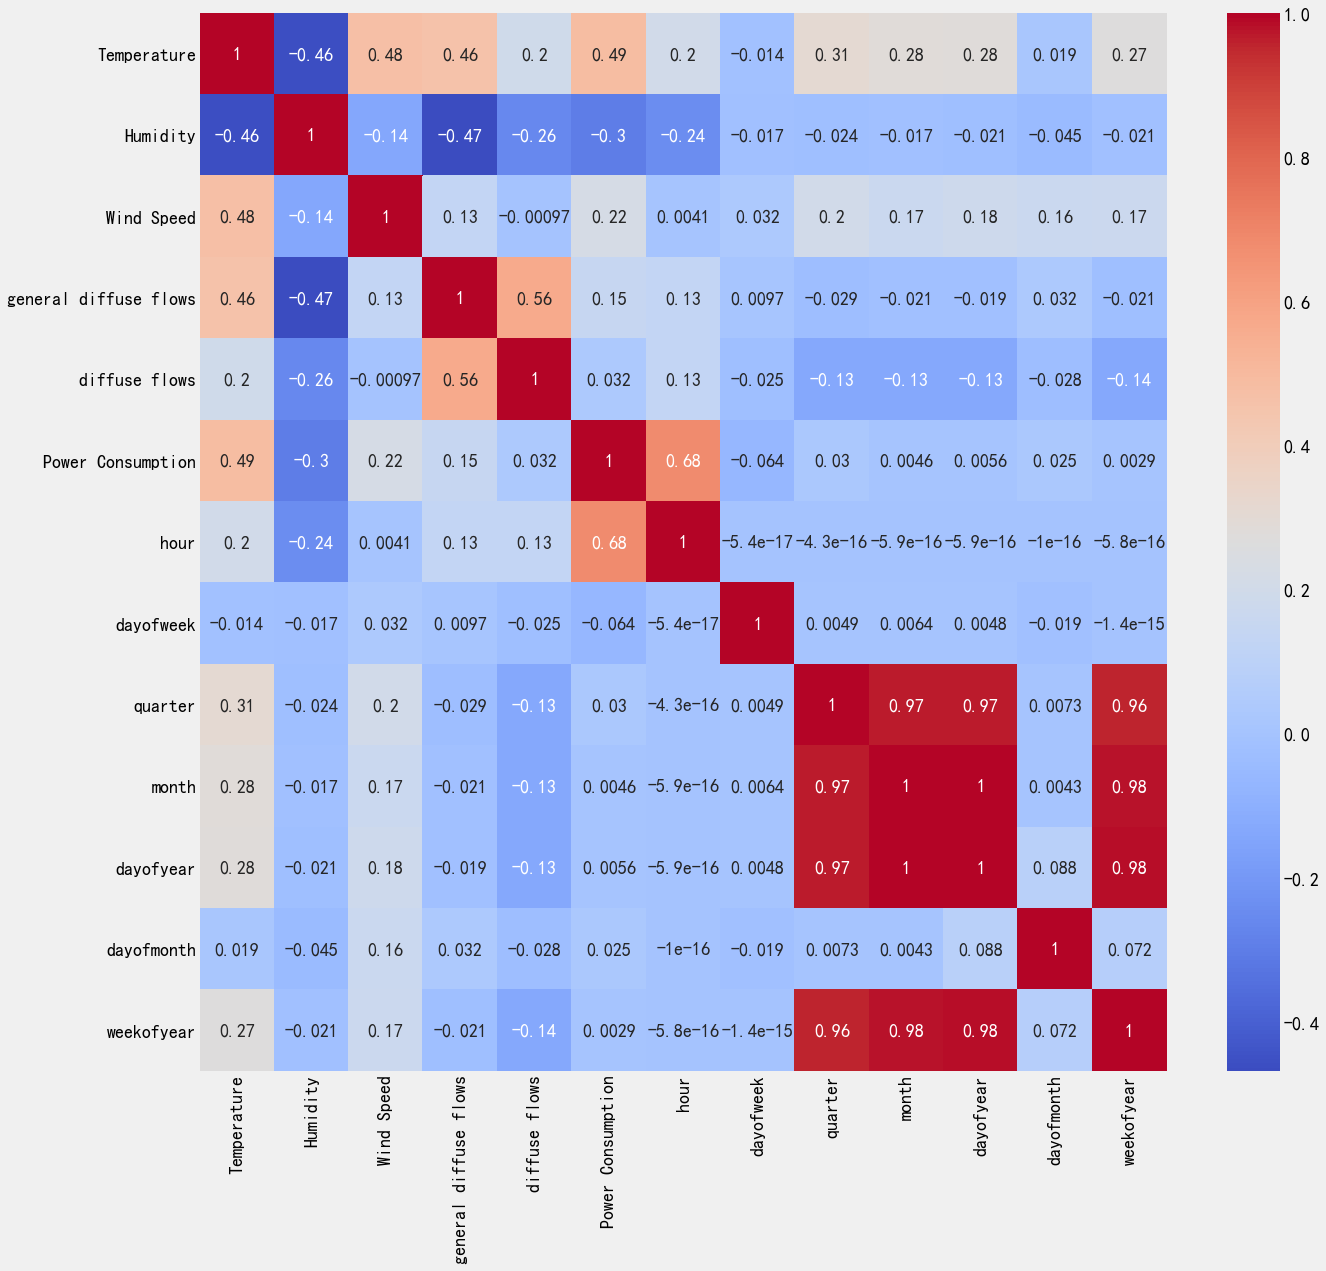

In [33]:
# 计算相关系数矩阵
plt.figure(figsize=(20, 18))

corr_matrix = df.corr()

# 绘制热图
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.tight_layout()
plt.savefig('corr.svg')
# 显示图像
plt.show()

### 实验结果分析

### 数据整体预测情况图表

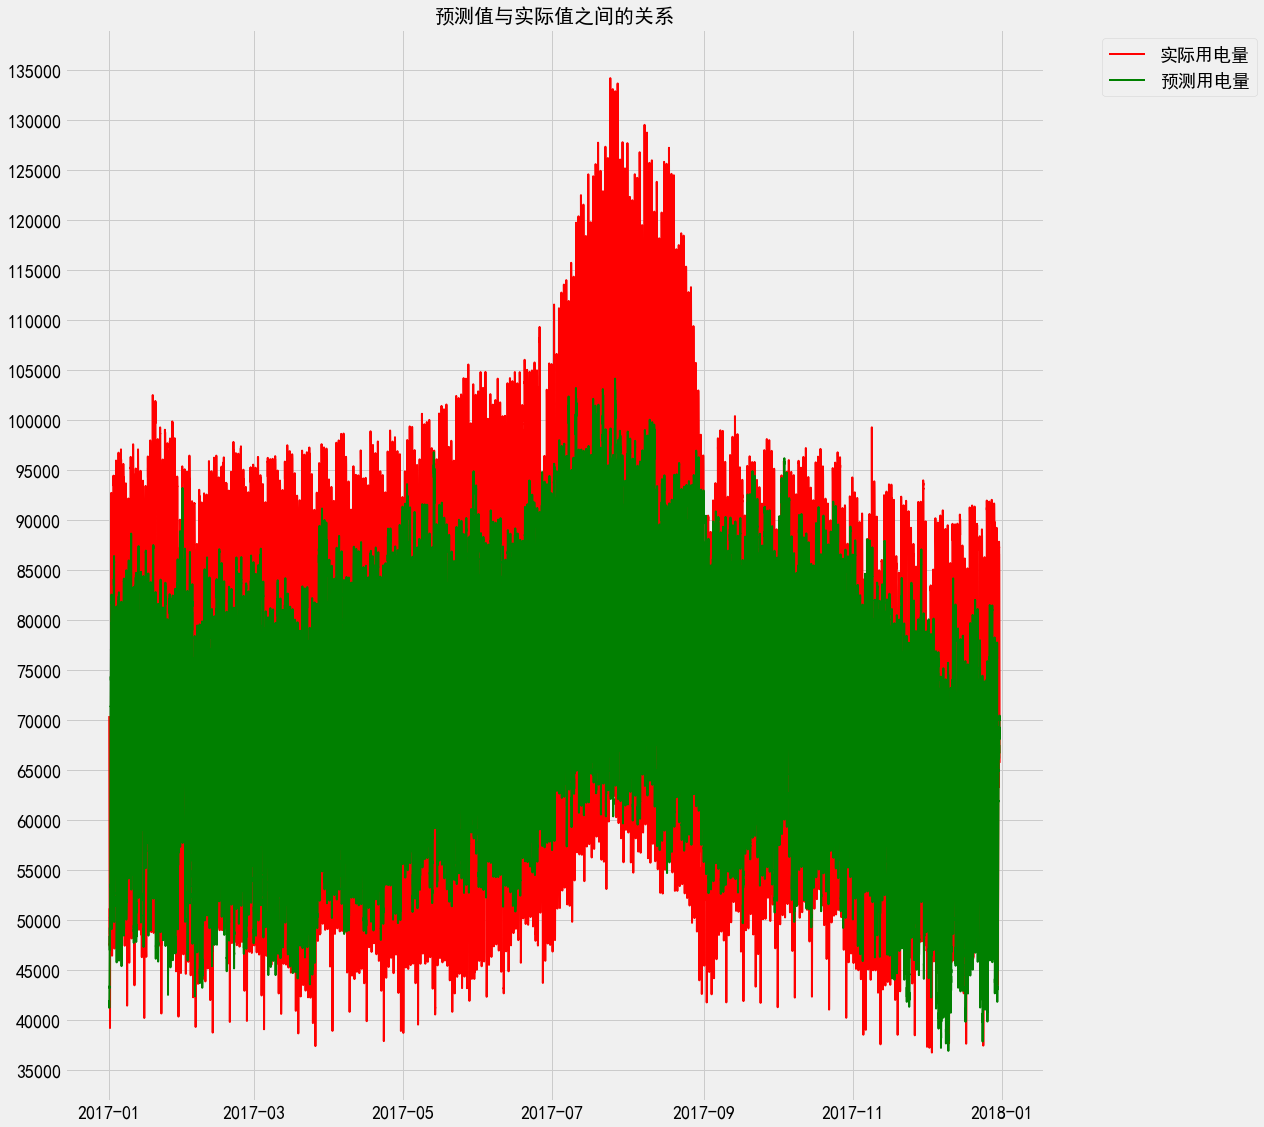

In [34]:
t = df.index

plt.figure(figsize=(18, 16))

plt.plot(t, y, 'r-', linewidth=2, label=u'实际用电量')
plt.plot(t, Y_pred, 'g-', linewidth=2, label=u'预测用电量')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(u"预测值与实际值之间的关系", fontsize=20)
plt.locator_params(axis='y', tight=True, nbins=40)

plt.tight_layout()
plt.savefig('res.svg')

plt.show()

### 11月中旬的预测值

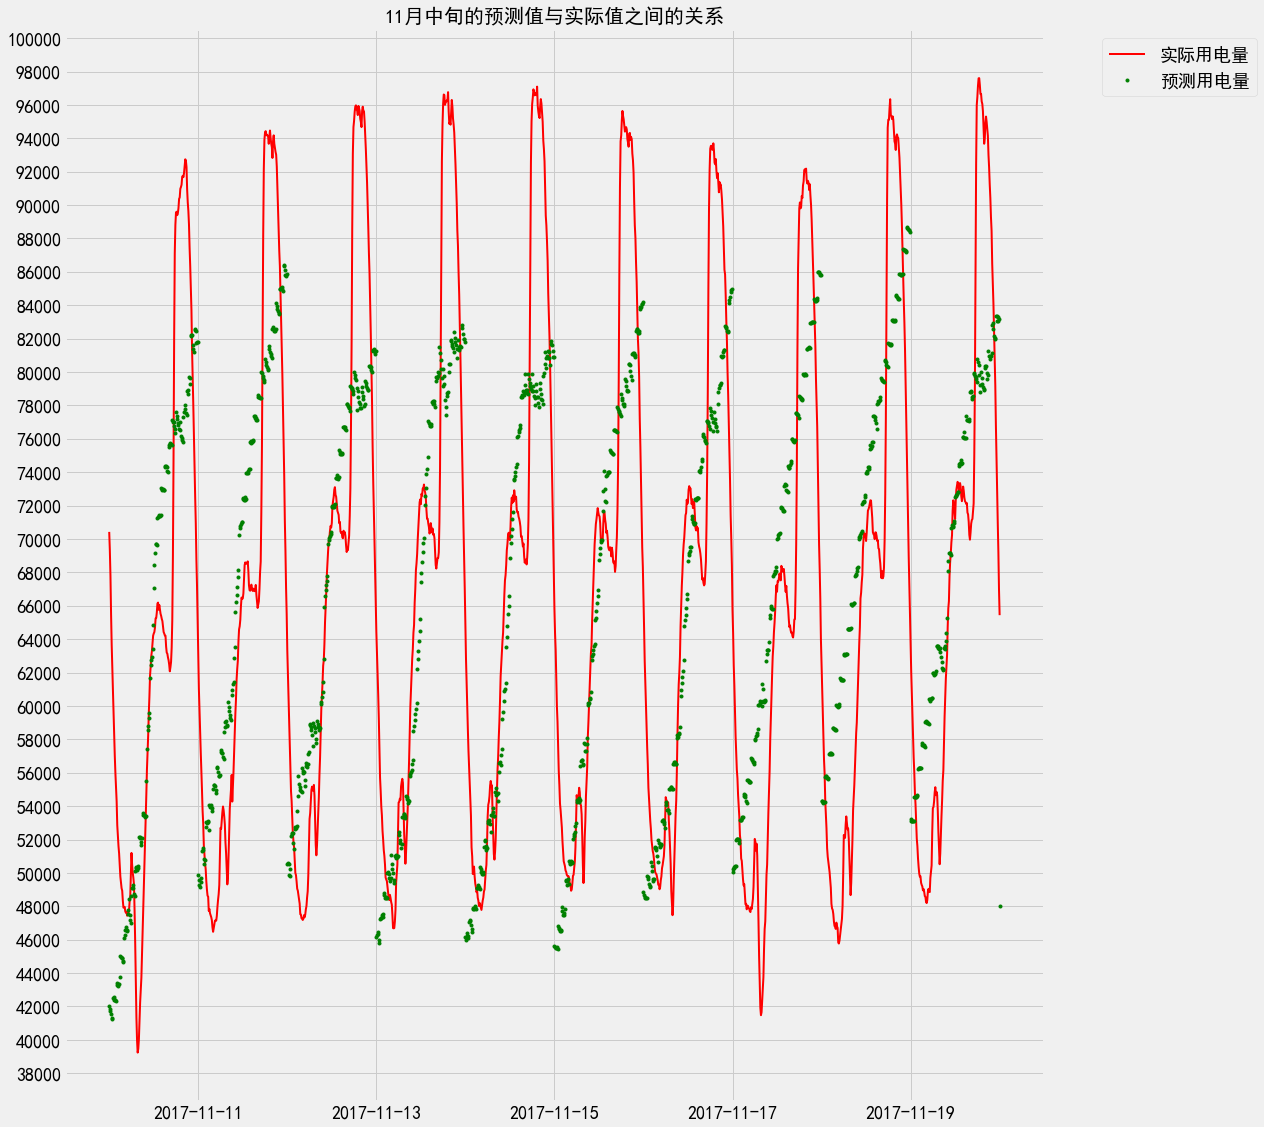

In [35]:
ndf = df.loc[(df.index <= '11-20-2017') & (df.index >= '11-10-2017')]
t = ndf.index
l = len(t)
plt.figure(figsize=(18, 16))

plt.plot(t, y[:l], 'r-', linewidth=2, label=u'实际用电量')
plt.plot(t, Y_pred[:l], 'g.', linewidth=2, label=u'预测用电量')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(u"11月中旬的预测值与实际值之间的关系", fontsize=20)
plt.locator_params(axis='y', tight=True, nbins=40)

plt.tight_layout()
plt.savefig('res_par.svg')

plt.show()